In [1]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from matplotlib import colormaps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import ast
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.stats import linregress
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import pdist, squareform



## grab subj data, and account for flips and shape-valence associations

In [2]:
df_subjs = pd.DataFrame()

for subj in ['amisha', 'tori', 'adam', 'erfan', '202509']:
    
    if not subj == 'rhia':
        df_subj = pd.read_csv(glob.glob(f'../results/*{subj}*')[0])[:240]
    else:
        df_subj = pd.read_csv(glob.glob(f'../results/*{subj}*')[0])[:40]
    df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)

    # store if flipped
    df_subj['flipped'] = np.where( df_subj['shape_order'] == 'curv_flat', 0, 1) 
   
    # convert str to list and store chosen position
    for col in ['positions']:
        if type(df_subj[col][0]) == str:
            df_subj[col] = df_subj[col].apply(lambda x: ast.literal_eval(x))
    df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
    
    # flips to ensure curvs are always on the left and flats on the right
    df_subj['chosen_pos_flipped'] = np.where( df_subj['flipped'] == 0, df_subj['chosen_pos'], -df_subj['chosen_pos'] )
    df_subj['div_true'] = np.where( df_subj['flipped'] == 0, df_subj['div_pos'], -df_subj['div_pos']) 

    # store correct class
    df_subj['class_true'] = np.where( df_subj['valence'] == 'rew', 1, 0 )

    if df_subj['sess_type'][0] in ['A', 'C']: # adam, tori
        
        # reassociate shape-valence
        df_subj['condition'] = df_subj['condition'].map({'baseline': 'baseline', 'curv_comp': 'pen_comp', 'flat_comp': 'rew_comp'})
        # store chosen class
        df_subj['class_pred'] = np.where( df_subj['chosen_pos_flipped'] > df_subj['div_true'], 1, 0 )

        # align positions to valence
        df_subj['chosen_pos_aligned'] = df_subj['chosen_pos_flipped']
        df_subj['stim_pos_aligned'] = df_subj['stim_pos']
        df_subj['div_true_aligned'] = df_subj['div_true']

    elif df_subj['sess_type'][0] in ['B', 'D']: # amisha, erfan
        
        # reassociate shape-valence
        df_subj['condition'] = df_subj['condition'].map({'baseline': 'baseline', 'curv_comp': 'rew_comp', 'flat_comp': 'pen_comp'})
        # store chosen class
        df_subj['class_pred'] = np.where( df_subj['chosen_pos_flipped'] < df_subj['div_true'], 1, 0 )
        
        # align positions to valence
        df_subj['chosen_pos_aligned'] = -df_subj['chosen_pos_flipped']
        df_subj['stim_pos_aligned'] = -df_subj['stim_pos']
        df_subj['div_true_aligned'] = -df_subj['div_true']

    df_subjs = pd.concat([df_subjs, df_subj], ignore_index=True)

# drop no slider move to no response submission
df_subjs = df_subjs.dropna(subset=['slider_resp.keys', 'submit_resp.keys'])

# compute y - y_hat
df_subjs['diff_pos'] = df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']

# convert outcomes +-2 to +-3
df_subjs['outcome'] = np.where( df_subjs['outcome'] == 2, 3, df_subjs['outcome'] )
df_subjs['outcome'] = np.where( df_subjs['outcome'] == -2, -3, df_subjs['outcome'] ) 

# norm RT
df_subjs['normed_RT'] = df_subjs['trials.submit_resp.rt']/ (df_subjs['diff_pos'] + .01)
print(df_subjs['outcome'].value_counts())

print(df_subjs.shape)
disp_cols = ['subj', 'sess_type', 'blockN', 'trial_key', 'condition', 'div_true_aligned', 'shape_order', 'flipped', 'div_pos', 'shape', 'valence', 'stim_pos', 'stim_pos_aligned', 'chosen_pos', 'chosen_pos_aligned', 'diff_pos', 'target_pos', 'chosen_pos', 'class_true', 'class_pred']
df_subjs[df_subjs['subj'] == 'tori'][disp_cols]
df_subjs[disp_cols][:40]


IndexError: list index out of range

## rhiannon

In [ ]:
df_subj = df_subjs[df_subjs['subj'] == '202509']

fig, axs = plt.subplots(3, 1, figsize=(6, 8))
axs, ax = axs.flatten(), 0
# plot info
light_blue, light_orange ='#64B5F6', '#FFB74D'
color_map = {False: light_orange, True: light_blue}
label_map = {False: 'incorrect', True: 'correct'}

# 1
axs[ax].hist(df_subj['chosen_pos_aligned'], bins=20, color=light_blue)
axs[ax].axhline(2, color='black', linestyle='--', label='true dist')
axs[ax].axvline(df_subj['div_true_aligned'].iloc[0], color='black', linestyle='-', label='divider')
axs[ax].set(title='predicted position', xlabel='penalizing        <--    shape position   -->        rewarding', ylabel='count', xlim=(-.4, .4))
ax += 1

# 2
for acc, acc_df in df_subj.groupby('correct'):        
    axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['diff_pos'],
                    color=color_map[acc], label=label_map[acc], alpha=0.7)
axs[ax].axhline(0, color='black', linestyle='--')
axs[ax].axvline(df_subj['div_true_aligned'].iloc[0], color='black', linestyle='-')
axs[ax].legend()
axs[ax].set(title='predicted position', xlabel='penalizing        <--    shape position   -->        rewarding', ylabel='error', xlim=(-.4, .4))
# fit line
slope, intercept, r_val, p_val, std_err = linregress(df_subj['stim_pos_aligned'], df_subj['diff_pos'])
x_fit = np.array(axs[ax].get_xlim())
y_fit = intercept + slope * x_fit
axs[ax].plot(x_fit, y_fit, linestyle='--', color=light_blue)
axs[ax].set_title(f'(r: {r_val:.2f})')
ax += 1

# 3
mean_metrics = df_subj.groupby('stim_pos_aligned')[['correct', 'normed_RT']].mean().reset_index()
# axs[ax].plot(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], marker='o')    
axs[ax].plot(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], marker='o')
axs[ax].axvline(df_subj['div_true_aligned'].iloc[0], color='black', linestyle='-')
axs[ax].set(xlabel='penalizing        <--    shape position   -->        rewarding', xlim=(-.4, .4))
ax += 1  

plt.tight_layout()
plt.show()

KeyError: 'subj'

KeyError: 'subj'

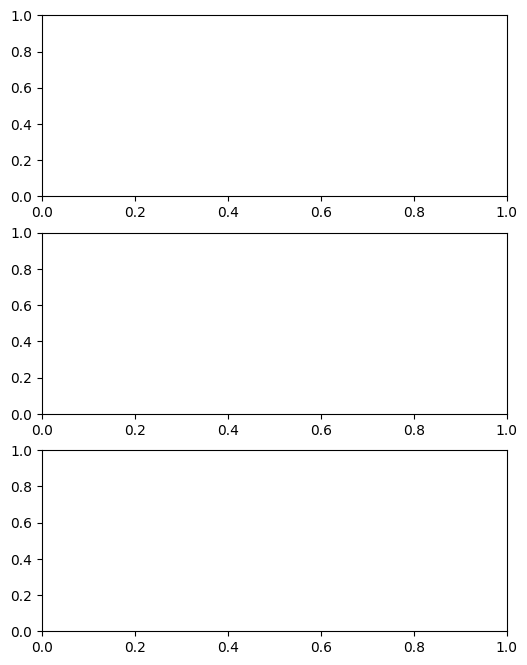

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8))
axs, ax = axs.flatten(), 0

# plot info
light_blue, light_orange ='#64B5F6', '#FFB74D'
color_map = {False: light_orange, True: light_blue}
label_map = {False: 'incorrect', True: 'correct'}

df_subj = df_subjs[df_subjs['subj'] == 'rhia']
# for cond, cond_df in df_subj[df_subjs['outcome'] != 0].groupby('condition'):
for cond, cond_df in df_subj.groupby('condition'):

    axs[ax].hist(cond_df['chosen_pos_aligned'], bins=20, color=light_blue)
    if cond == 'baseline':
        axs[ax].axhline(16, color='black', linestyle='--', label='true dist')
    elif cond == 'pen_comp':
        axs[ax].hlines(32, -.4, -.2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(16, -.2, .2, color='black', linestyle='--', label='true dist')
    elif cond == 'rew_comp':
        axs[ax].hlines(16, -.2, .2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(32, .2, .4, color='black', linestyle='--', label='true dist')
    axs[ax].axvline(cond_df['div_true_aligned'].iloc[0], color='black', linestyle='-', label='divider')
    axs[ax].set(title='predicted position', xlabel='penalizing        <--    shape position   -->        rewarding', ylabel='count', xlim=(-.4, .4))
    axs[ax].set_title(f'{cond}')
    ax += 1

    # mean_metrics = cond_df.groupby('stim_pos_aligned')[['correct', 'normed_RT']].mean().reset_index()
    # axs[ax].plot(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], marker='o')    
    # # axs[ax].plot(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], marker='o')
    # axs[ax].axvline(cond_df['div_true_aligned'].iloc[0], color='black', linestyle='-')
    # axs[ax].set(title=f'{cond}', xlabel='penalizing        <--    shape position   -->        rewarding', xlim=(-.4, .4))
    # ax += 1  

    # for acc, acc_df in cond_df.groupby('correct'):        
    #     axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['diff_pos'],
    #                     color=color_map[acc], label=label_map[acc], alpha=0.7)
    # axs[ax].axhline(0, color='black', linestyle='--')
    # axs[ax].axvline(cond_df['div_true_aligned'].iloc[0], color='black', linestyle='-')
    # axs[ax].legend()
    # axs[ax].set(title='predicted position', xlabel='penalizing        <--    shape position   -->        rewarding', ylabel='error', xlim=(-.4, .4))
    # # fit line
    # slope, intercept, r_val, p_val, std_err = linregress(cond_df['stim_pos_aligned'], cond_df['chosen_pos_aligned']-cond_df['stim_pos_aligned'])
    # x_fit = np.array(axs[ax].get_xlim())
    # y_fit = intercept + slope * x_fit
    # axs[ax].plot(x_fit, y_fit, linestyle='--', color=light_blue)
    # axs[ax].set_title(f'{cond} (r: {r_val:.2f})')
    # ax += 1

plt.tight_layout()
plt.show()
fig.subplots_adjust(hspace=0.8, wspace=0.4)


## plot class - class_hat

In [ ]:
# Step 1: Get mean accuracy per subject (across all conditions and valences)
subj_acc = df_subjs.groupby('subj')['correct'].mean().reset_index()

# Step 2: Compute SD across those subject-level accuracies
overall_sd = subj_acc['correct'].std()

print(f"SD across subjects: {overall_sd}")


KeyError: 'subj'

In [ ]:
# compute subject-level accuracy by valence & condition
subj_acc_df = df_subjs.groupby(['subj','condition','valence'])['correct'].mean().reset_index()

subj_acc_df['x_label'] = subj_acc_df['valence'].astype(str) + '\n' + subj_acc_df['condition'].astype(str)

# assign colors to subjects
subj_palette = dict(zip(subj_acc_df['subj'].unique(),
                        sns.color_palette('husl', n_colors=subj_acc_df['subj'].nunique())))

# compute population mean by condition & valence
pop_acc_df = subj_acc_df.groupby(['condition','valence'])['correct'].mean().reset_index()
pop_acc_df['x_label'] = pop_acc_df['valence'].astype(str) + '\n' + pop_acc_df['condition'].astype(str)

fig, axs = plt.subplots(2, 2, figsize=(12, 5))
axs, ax = axs.flatten(), 0

axs[ax].set_title('Accuracy')
# plot subjs
for subj, sub_df in subj_acc_df.groupby('subj'):
    for cond, cond_df in sub_df.groupby('condition'):
        axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                     color=subj_palette[subj], alpha=0.6)

# plot population
for cond, cond_df in pop_acc_df.groupby('condition'):
    axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                 color='black', marker='o', linewidth=2)

axs[ax].set(ylabel='proportion', ylim=(.5, 1))
ax += 1

# post error behavior
axs[ax].set_title('Post-error behavior')
df_post_err = df_subjs[df_subjs['correct'].shift(-1) == False]

plt.tight_layout()
plt.show()


KeyError: 'subj'

## get alexnet embeddings of stims used in expt

In [ ]:
# # load pretrainded AlexNet model
# model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# # remove the last layer to get the feature vector
# model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# # transform the input image to the format expected by the model
# transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# def get_embeddings(img_path):
#     img = np.array(Image.open(img_path).convert('RGB'))
#     # img = np.clip(img + np.random.normal(loc=0.0, scale=100, size=img.shape), 0, 255)
#     img = Image.fromarray(img.astype(np.uint8))
#     img = transform(img).unsqueeze(0)
#     with torch.no_grad():
#     # with torch.no_grad() is used to disable gradient calculation
#         return model(img)
    
    
# # 1. Load trial metadata
# trials_df = pd.read_csv('../input_data/trials_no_noise.csv')
# shape_files_used = trials_df['target_file'].tolist()

# # 2. Extract AlexNet embeddings

# alex_embeds = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in tqdm(shape_files_used)]
# embedding_matrix = np.stack([v.squeeze().numpy() for _, v in alex_embeds])
# shape_names = [k for k, _ in alex_embeds]

# # 3. Apply PCA to embeddings
# pca = PCA(n_components=64)
# pca_features = pca.fit_transform(embedding_matrix)
# # add noise
# # pca_features += np.random.normal(loc=0.0, scale=1, size=pca_features.shape)

# # 4. Form DataFrame: shape name + PCA features
# pca_cols = [f'feature_{i}' for i in range(pca_features.shape[1])]
# alexnet_df = pd.DataFrame(pca_features, columns=pca_cols)
# alexnet_df.insert(0, 'shapes', shape_names)

# # 5. Append more metadata
# alexnet_df[['blockN', 'condition', 'stim_pos', 'target_pos', 'noise_pos', 'div_pos']] = trials_df[['blockN', 'condition', 'stim_pos', 'target_pos', 'noise_pos', 'div_pos']]
# alexnet_df['flipped'] = np.where( trials_df['shape_order'] == 'curv_flat', 0, 1) 
# alexnet_df['condition'] = trials_df['condition'].map({'baseline': 'baseline', 'curv_comp': 'pen_comp', 'flat_comp': 'rew_comp'})
# alexnet_df['div_true'] = alexnet_df['condition'].map({'baseline': 0, 'pen_comp': -.2, 'rew_comp': .2})
# alexnet_df['class_true'] = np.where( trials_df['shape'] == 'flat', 1, 0 )

# # 7. Reorder and save
# reorder_columns = ['shapes', 'blockN', 'condition', 'div_true', 'flipped', 'div_pos', 'stim_pos', 'target_pos', 'class_true', 'noise_pos'] + pca_cols
# alexnet_df = alexnet_df[reorder_columns]

# alexnet_df.to_csv('../input_data/alex_embeds.csv', index=False)


In [ ]:
alexnet_df = pd.read_csv('../../data/alex_embeds.csv')
print(alexnet_df.shape)
alexnet_df[:40]
alexnet_df.iloc[75:85]

(240, 74)


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
75,input_data/stims/Shape_2.50_2.00.png,2,pen_comp,-0.2,1,0.2,0.10,-0.10,1,2.0,...,-8.831267e-08,5.123801e-08,-2.106847e-07,8.713791e-08,5.753961e-08,-3.968892e-07,-6.011383e-09,-2.170691e-12,4.267947e-13,2.303932e-13
76,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,0,-0.2,0.14,0.14,1,2.0,...,4.312146e-07,-4.189825e-07,8.722235e-08,6.269611e-07,-4.692531e-08,-4.121116e-07,-6.245890e-09,-2.684568e-12,-3.266230e-13,4.453828e-13
77,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,1,0.2,0.14,-0.14,1,2.0,...,4.312146e-07,-4.189825e-07,8.722235e-08,6.269611e-07,-4.692531e-08,-4.121116e-07,-6.245890e-09,-2.684568e-12,-3.266230e-13,4.453828e-13
78,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,0,-0.2,0.18,0.18,1,2.0,...,-1.798626e-07,1.377952e-07,1.302390e-07,7.495400e-08,-7.520322e-07,-2.622340e-08,5.814895e-10,7.312404e-12,2.450091e-13,-6.266583e-15
79,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,1,0.2,0.18,-0.18,1,2.0,...,-1.798626e-07,1.377952e-07,1.302390e-07,7.495400e-08,-7.520322e-07,-2.622340e-08,5.814895e-10,7.312404e-12,2.450091e-13,-6.266583e-15
80,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,0,0.2,-0.18,-0.18,0,2.0,...,2.448320e-14,-4.158635e-14,3.969743e-14,5.994181e-14,-5.737620e-14,1.269725e-13,-2.324622e-12,4.622141e-12,2.396458e-11,-4.025953e-11
81,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,1,-0.2,-0.18,0.18,0,2.0,...,2.448320e-14,-4.158635e-14,3.969743e-14,5.994181e-14,-5.737620e-14,1.269725e-13,-2.324622e-12,4.622141e-12,2.396458e-11,-4.025953e-11
82,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,0,0.2,-0.14,-0.14,0,2.0,...,-3.142521e-14,4.061201e-14,-6.416470e-14,-9.437873e-14,5.207621e-14,-4.297357e-14,-6.472258e-15,-3.391510e-14,-5.943299e-14,-1.862367e-13
83,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,1,-0.2,-0.14,0.14,0,2.0,...,-3.142521e-14,4.061201e-14,-6.416470e-14,-9.437873e-14,5.207621e-14,-4.297357e-14,-6.472258e-15,-3.391510e-14,-5.943299e-14,-1.862367e-13
84,input_data/stims/Shape_1.50_2.00.png,3,rew_comp,0.2,0,0.2,-0.10,-0.10,0,2.0,...,-1.165713e-14,8.714375e-14,1.109762e-14,-2.027203e-13,1.358740e-14,1.638100e-14,1.113070e-15,-3.092686e-15,5.472857e-14,-1.953897e-14


## plot stim embeddings from alexnet

alex_embeds_df.shape (n_trials, n_feats): (240, 64)


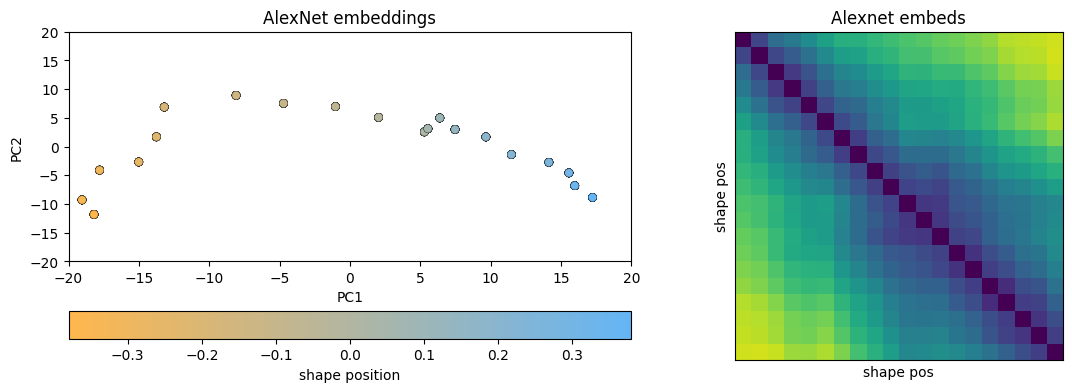

In [ ]:
# sub-select cols
alex_embeds_df = alexnet_df[alexnet_df.columns[alexnet_df.columns.str.startswith('feature_')]]
print(f'alex_embeds_df.shape (n_trials, n_feats): {alex_embeds_df.shape}')

pca = PCA(n_components=2)
alex_feat_pc_df = pd.DataFrame(pca.fit_transform(alex_embeds_df),
                               columns=['PC1', 'PC2'])


cmap = LinearSegmentedColormap.from_list('orange_blue', ['#FFB74D', '#64B5F6'])


feat_by_shape = alex_embeds_df.groupby(alexnet_df['shapes']).mean()
shape_rdm = squareform(pdist(feat_by_shape.values, metric='euclidean'))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs, ax = axs.flatten(), 0

# shape PCA
sc = axs[ax].scatter(alex_feat_pc_df['PC1'], alex_feat_pc_df['PC2'],
                     c=alexnet_df['stim_pos'].values, cmap=cmap, edgecolor='k', linewidth=0.2)
fig.colorbar(sc, ax=axs[ax], label='shape position', orientation='horizontal')
axs[ax].set(title='AlexNet embeddings', xlabel='PC1', ylabel='PC2', xlim=(-20,20), ylim=(-20,20))
ax += 1

# shape RDM
im = axs[ax].imshow(shape_rdm, cmap='viridis', vmin=0, vmax=40)
# fig.colorbar(im, ax=axs[ax], fraction=0.046, pad=0.04, orientation='horizontal')
axs[ax].set_xticks([])
axs[ax].set_yticks([])
axs[ax].set(title='Alexnet embeds', xlabel='shape pos', ylabel='shape pos')

plt.tight_layout()
plt.show()


## building architecture of new NN

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, recon_dim, class_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, recon_dim)
        self.classification_output = nn.Linear(hidden_dim, class_dim)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # classification = torch.sigmoid(self.classification_output(x))
        classification = self.classification_output(x)
        
        return reconstruction, classification

## format features (X) & predictions (y_reg & y_class)

In [ ]:
# 1.
feature_cols = [col for col in alexnet_df.columns if col.startswith('feature_')]
# features = alex embeds + div_pos + flipped
# X = np.column_stack((alexnet_df[feature_cols].values,
#                      alexnet_df['div_pos'].values,alexnet_df['flipped'].values))
X = np.column_stack((alexnet_df[feature_cols].values, alexnet_df['div_true'].values))

# 2.
y_class = alexnet_df['class_true'].values.reshape(-1, 1) # shape class (0 or 1)

# 3.
y_reg = alexnet_df['target_pos'].values.reshape(-1, 1) # regression target
# y_reg = df_subjs[df_subjs['subj'] == 'amisha']['chosen_pos'].values.reshape(-1, 1)

y_reg = alexnet_df['stim_pos'].values.reshape(-1, 1) # regression target
print(y_reg.tolist())

print(f'X.shape (n_trials, n_feats + div_cntxt): {X.shape}')

def weight_per_sample(labels, preds, tp, tn, fp, fn):
    weights = torch.ones_like(preds)  # init to all 1s
    weights[(labels == 1) & (preds == 1)] = tp  # true positive
    weights[(labels == 0) & (preds == 0)] = tn  # true negative
    weights[(labels == 0) & (preds == 1)] = fp  # false positive
    weights[(labels == 1) & (preds == 0)] = fn  # false negative
    return weights

[[-0.38], [-0.38], [-0.34], [-0.34], [-0.3], [-0.3], [-0.26], [-0.26], [-0.22], [-0.22], [-0.18], [-0.18], [-0.14], [-0.14], [-0.1], [-0.1], [-0.06], [-0.06], [-0.02], [-0.02], [0.02], [0.02], [0.06], [0.06], [0.1], [0.1], [0.14], [0.14], [0.18], [0.18], [0.22], [0.22], [0.26], [0.26], [0.3], [0.3], [0.34], [0.34], [0.38], [0.38], [-0.38], [-0.38], [-0.38], [-0.38], [-0.34], [-0.34], [-0.34], [-0.34], [-0.3], [-0.3], [-0.3], [-0.3], [-0.26], [-0.26], [-0.26], [-0.26], [-0.22], [-0.22], [-0.22], [-0.22], [-0.18], [-0.18], [-0.14], [-0.14], [-0.1], [-0.1], [-0.06], [-0.06], [-0.02], [-0.02], [0.02], [0.02], [0.06], [0.06], [0.1], [0.1], [0.14], [0.14], [0.18], [0.18], [-0.18], [-0.18], [-0.14], [-0.14], [-0.1], [-0.1], [-0.06], [-0.06], [-0.02], [-0.02], [0.02], [0.02], [0.06], [0.06], [0.1], [0.1], [0.14], [0.14], [0.18], [0.18], [0.22], [0.22], [0.22], [0.22], [0.26], [0.26], [0.26], [0.26], [0.3], [0.3], [0.3], [0.3], [0.34], [0.34], [0.34], [0.34], [0.38], [0.38], [0.38], [0.38], [-0

## cross-validation

reg_wt: 0.01, class_wt: 0.99, tp: 6, tn: 4, fp: 0, fn: 2
random state: 444


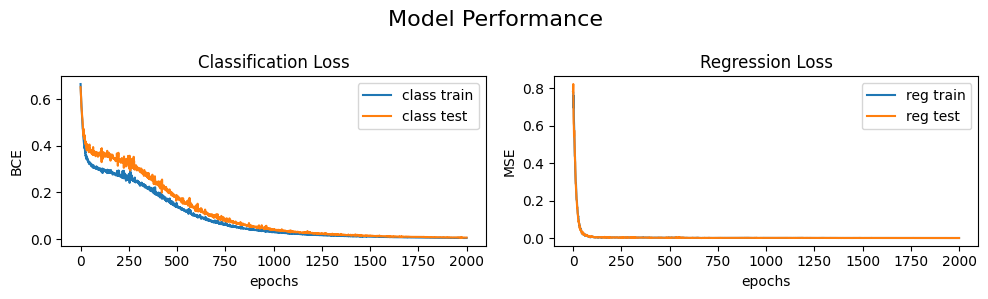

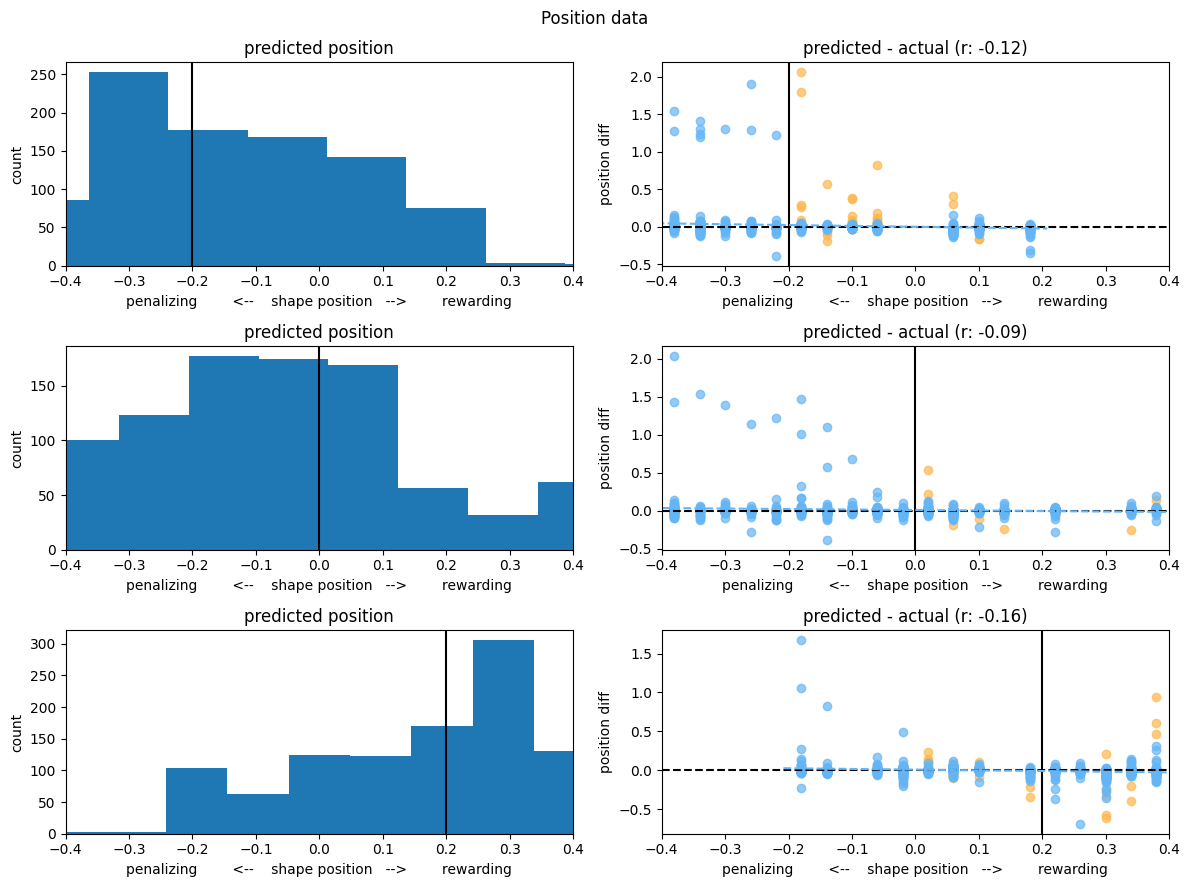

correct
True     2746
False     134
Name: count, dtype: int64


,div,y_reg,pred_reg,y_class,pred_class_classHead,pred_class_regHead,correct,diff_pos
0,-0.2,-0.22,1.008143,0.0,True,0.0,True,1.228143
1,0.0,0.14,-0.095964,1.0,False,0.0,False,-0.235964
2,0.0,-0.30,1.098327,0.0,True,0.0,True,1.398327
3,0.2,0.30,-0.276903,1.0,False,0.0,False,-0.576903
4,0.0,0.10,-0.005662,1.0,False,0.0,False,-0.105662
...,...,...,...,...,...,...,...,...
2875,0.2,0.34,0.336244,1.0,True,1.0,True,-0.003756
2876,0.0,-0.22,-0.231747,0.0,False,0.0,True,-0.011747
2877,-0.2,0.10,0.081739,1.0,True,1.0,True,-0.018261
2878,0.2,0.10,0.093035,0.0,False,0.0,True,-0.006965


In [ ]:
# architecture params
input_dim, hidden_dim, reg_dim, class_dim = X.shape[1], 64, y_reg.shape[1], 1
model = ShapeSideNN(input_dim, hidden_dim, reg_dim, class_dim)

# loss params
optimizer = optim.Adam(model.parameters(), lr=0.001)
reg_wt, class_wt = .01, .99
tp, tn, fp, fn = 6, 4, 0, 2
# tp, tn, fp, fn = 1, 1, 1, 1
print(f'reg_wt: {reg_wt}, class_wt: {class_wt}, tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}')

rand_state = np.random.randint(0, 1000)
# rand_state = 145
# ANN seeds: 334, 517, 145
# ANN asymmetric seeds: 
# NN seeds: amisha , erfan , tori 726, adam 
print(f'random state: {rand_state}')

train_total_losses, train_reg_losses, train_class_losses = [], [], []
test_total_losses, test_reg_losses, test_class_losses = [], [], []
div_tests, all_flips, y_reg_tests, pred_reg_tests, y_class_tests, pred_class_classHeads, pred_class_regHeads, all_epochs = [], [], [], [], [], [], [], []
tst_corrects = []
epochs = 2000

# training loop
for epoch in range(epochs):

    # add noise
    X_noised = X.copy()
    X_noised[:, :-1] += np.random.normal(loc=0.0, scale=2.5, size=X_noised[:, :-1].shape)
    # add vertical (across-shape) noise, but avoid the last column (divider)
    jitter = np.random.normal(loc=0.0, scale=1.0, size=(X.shape[0], 1))
    X_noised = np.hstack([X[:, :-1] + jitter, X[:, -1:]])

    # split into train and test
    X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
        X_noised, y_reg, y_class, test_size=.3, stratify=y_class, shuffle=True, random_state=rand_state
    )

    # convert ys to tensors to be able to compare against preds
    y_reg_train, y_class_train = torch.tensor(y_reg_train, dtype=torch.float32), torch.tensor(y_class_train, dtype=torch.float32)
    y_reg_test, y_class_test = torch.tensor(y_reg_test, dtype=torch.float32), torch.tensor(y_class_test, dtype=torch.float32)
   

   # training
    model.train()

    # forward pass to predict regstruction & class
    pred_reg_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

    # compute train loss
    train_reg_loss, train_class_loss = nn.MSELoss()(pred_reg_train, y_reg_train), nn.BCEWithLogitsLoss()(pred_class_train, y_class_train)
    train_total_loss = (reg_wt * train_reg_loss) + (class_wt * train_class_loss)

    # backward pass and optimization
    optimizer.zero_grad()
    train_total_loss.backward()
    
    # to try to take care of exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # testing model
    model.eval()
    with torch.no_grad():

        # predict test shape & class using trained model
        pred_reg_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        
        
        # store predicted class for plotting
        # option 1: based on classification output
        pred_class_regHead = (pred_class_test >= 0).float()
        # option 2: based on regression output
        divider = torch.tensor(X_test[:, -1], dtype=torch.float32).unsqueeze(1)
        pred_class_classHead = pred_reg_test > divider

        # compute test loss
        test_reg_loss, test_class_loss = nn.MSELoss()(pred_reg_test, y_reg_test), nn.BCEWithLogitsLoss()(pred_class_test, y_class_test)
        test_total_loss = (reg_wt * test_reg_loss) + (class_wt * test_class_loss)

    # appending train & test losses
    train_reg_losses.append(train_reg_loss.item())
    train_class_losses.append(train_class_loss.item())
    train_total_losses.append(train_total_loss.item())

    test_reg_losses.append(test_reg_loss.item())
    test_class_losses.append(test_class_loss.item())
    test_total_losses.append(test_total_loss.item())

    if epoch % 50 == 0:
        # appending ys, preds, divs, flips
        div_tests.append(X_test[:, -1])  # divider
        y_reg_tests.append(y_reg_test.squeeze().numpy().flatten())
        pred_reg_tests.append(pred_reg_test.squeeze().numpy().flatten())
        y_class_tests.append(y_class_test.squeeze().numpy().flatten())
        # pred_class_tests.append(pred_class_test_binarized.squeeze().numpy().flatten())
        pred_class_classHeads.append(pred_class_classHead.squeeze().numpy().flatten())
        pred_class_regHeads.append(pred_class_regHead.squeeze().numpy().flatten())


# create a df out of model outputs
df_outputs = pd.DataFrame({
    'div': np.concatenate(div_tests),
    'y_reg': np.concatenate(y_reg_tests),
    'pred_reg': np.concatenate(pred_reg_tests),
    'y_class': np.concatenate(y_class_tests),
    'pred_class_classHead': np.concatenate(pred_class_classHeads),
    'pred_class_regHead': np.concatenate(pred_class_regHeads),
})
df_outputs['correct'] = np.where(df_outputs['y_class'] == df_outputs['pred_class_classHead'], True, False)
df_outputs['correct'] = np.where(df_outputs['y_class'] == df_outputs['pred_class_regHead'], True, False)
df_outputs['diff_pos'] = df_outputs['pred_reg'] - df_outputs['y_reg']

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs, ax = axs.flatten(), 0
fig.suptitle('Model Performance', fontsize=16)

# 1. class loss
axs[ax].plot(train_class_losses, label='class train')
axs[ax].plot(test_class_losses, label='class test')
axs[ax].legend()
axs[ax].set(title='Classification Loss', xlabel='epochs', ylabel='BCE')
ax += 1

# 2. reg loss
axs[ax].plot(train_reg_losses, label='reg train')
axs[ax].plot(test_reg_losses, label='reg test')
axs[ax].legend()
axs[ax].set(title='Regression Loss', xlabel='epochs', ylabel='MSE')
ax += 1

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs, ax = axs.flatten(), 0

for cond, cond_df in df_outputs.groupby('div'):

    axs[ax].hist(cond_df['pred_reg'], bins=20)
    # axs[ax].axhline(16, color='black', linestyle='--', label='true dist')
    axs[ax].axvline(cond_df['div'].iloc[0], color='black', linestyle='-', label='divider')
    axs[ax].set(title='predicted position', xlabel='penalizing        <--    shape position   -->        rewarding', ylabel='count', xlim=(-.4, .4))
    ax += 1    

    # axs[ax].scatter(cond_df['y_reg'], cond_df['pred_reg']-cond_df['y_reg'])
    for corr, sub_df in cond_df.groupby('correct'):
        axs[ax].scatter(sub_df['y_reg'], sub_df['diff_pos'],
                        color=color_map[corr], label=label_map[corr], alpha=0.7)
    axs[ax].axhline(0, color='black', linestyle='--')
    axs[ax].axvline(cond_df['div'].iloc[0], color='black', linestyle='-')
    # fit line
    slope, intercept, r_val, p_val, std_err = linregress(cond_df['y_reg'], cond_df['diff_pos'])
    x_fit = np.array(axs[ax].get_xlim())
    y_fit = intercept + slope * x_fit
    axs[ax].plot(x_fit, y_fit, linestyle='--', color=light_blue)
    axs[ax].set(title=f'predicted - actual (r: {r_val:.2f})', xlabel='penalizing        <--    shape position   -->        rewarding', ylabel='position diff', xlim=(-.4, .4))
    ax += 1

plt.suptitle('Position data')
plt.tight_layout()
plt.show()

print(df_outputs['correct'].value_counts())
df_outputs


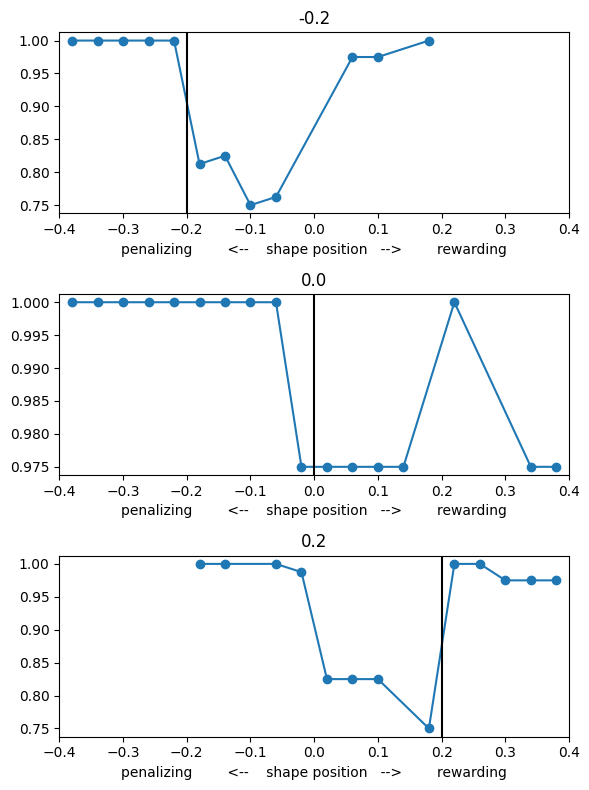

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8))
axs, ax = axs.flatten(), 0

for cond, cond_df in df_outputs.groupby('div'):

    mean_metrics = cond_df.groupby('y_reg')['correct'].mean().reset_index()
    axs[ax].plot(mean_metrics['y_reg'], mean_metrics['correct'], marker='o')    
    axs[ax].axvline(cond_df['div'].iloc[0], color='black', linestyle='-')
    axs[ax].set(title=f'{cond}', xlabel='penalizing        <--    shape position   -->        rewarding', xlim=(-.4, .4))
    ax += 1  

plt.tight_layout()
plt.show()
fig.subplots_adjust(hspace=0.8, wspace=0.4)


In [ ]:
acc = df_outputs['correct'].mean()
print(f"Accuracy: {acc:.2%}")  # prints as percentage, e.g., "Accuracy: 78.00%"


Accuracy: 95.35%


In [ ]:
# # architecture params
# input_dim, hidden_dim, reg_dim, class_dim = X.shape[1], 64, y_reg.shape[1], 1
# model = ShapeSideNN(input_dim, hidden_dim, reg_dim, class_dim)

# # loss params
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# reg_wt, class_wt = .2, .8
# tp, tn, fp, fn = 6, 4, 0, 2
# tp, tn, fp, fn = 1, 1, 1, 1
# print(f'reg_wt: {reg_wt}, class_wt: {class_wt}, tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}')

# rand_state = np.random.randint(0, 1000)
# # rand_state = 145
# # ANN seeds: 334, 517, 145
# # ANN asymmetric seeds: 
# # NN seeds: amisha , erfan , tori 726, adam 
# print(f'random state: {rand_state}')

# train_total_losses, train_reg_losses, train_class_losses = [], [], []
# test_total_losses, test_reg_losses, test_class_losses = [], [], []
# all_divs, all_flips, all_y_reg, all_pred_reg, all_y_class, all_pred_class, all_epochs = [], [], [], [], [], [], []

# epochs = 2500

# # training loop
# for epoch in range(epochs):

#     # split into train and test
#     X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
#         X, y_reg, y_class, test_size=.3, stratify=y_class, shuffle=True, random_state=rand_state
#     )

#     # convert ys to tensors to be able to compare against preds
#     y_reg_train, y_class_train = torch.tensor(y_reg_train, dtype=torch.float32), torch.tensor(y_class_train, dtype=torch.float32)
#     y_reg_test, y_class_test = torch.tensor(y_reg_test, dtype=torch.float32), torch.tensor(y_class_test, dtype=torch.float32)
   
#     model.train()

#     # forward pass to predict regstruction & class
#     pred_reg_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

#     # 1. regstruction loss between pred & y
#     train_reg_loss = nn.MSELoss()(pred_reg_train, y_reg_train)

#     # 2. class loss
#     train_class_loss = nn.BCEWithLogitsLoss()(pred_class_train, y_class_train)

#     # 2. classification loss
#     # a. first get BCE per sample
#     # no reduction means it unpacks, doesnt just avg out samples
#     bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_train, y_class_train)
    
#     # b. next, get binary classes
#     pred_class_train_binarized = (torch.sigmoid(pred_class_train) >= .5).float()

#     # c. get weight per sample depending on (true, pred)
#     wts = weight_per_sample(y_class_train.squeeze(), pred_class_train_binarized.squeeze(), tp, tn, fp, fn)

#     # d. weighted error
#     train_class_loss = (wts * bce).mean()

#     # 3. weighted summed training loss
#     train_total_loss = (reg_wt * train_reg_loss) + (class_wt * train_class_loss)

#     # backward pass and optimization
#     optimizer.zero_grad()
#     train_total_loss.backward()
#     # to try to take care of exploding gradients (manifested as sudden, high losses)?
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()

#     # testing model
#     model.eval()
#     with torch.no_grad():

#         # predict test shape & class using trained model
#         pred_reg_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        

#         # 1. reg losses between pred & y
#         test_reg_loss = nn.MSELoss()(pred_reg_test, y_reg_test)

#         # 2. class loss
#         test_class_loss = nn.BCEWithLogitsLoss()(pred_class_test, y_class_test)

#         # 2. class loss
#         # a. first get BCE per sample
#         # no reduction means it unpacks, doesnt just avg out samples
#         bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_test, y_class_test)
        
#         # b. next, get binary classes
#         pred_class_test_binarized = (torch.sigmoid(pred_class_test) >= .5).float()

#         # c. get weight per sample depending on (true, pred)
#         wts = weight_per_sample(y_class_test.squeeze(), pred_class_test_binarized.squeeze(), tp, tn, fp, fn)

#         # d. weighted error
#         test_class_loss = (wts * bce).mean()
    
#         # 3. weighted summed testing loss
#         test_total_loss = (reg_wt * test_reg_loss) + (class_wt * test_class_loss)

#     # appending train & test losses
#     train_reg_losses.append(train_reg_loss.item())
#     train_class_losses.append(train_class_loss.item())
#     train_total_losses.append(train_total_loss.item())

#     test_reg_losses.append(test_reg_loss.item())
#     test_class_losses.append(test_class_loss.item())
#     test_total_losses.append(test_total_loss.item())

#     if epoch % 100 == 0:
#         # appending ys, preds, divs, flips
#         all_divs.append(X_test[:, -2])  # divider
#         all_flips.append(X_test[:, -1])  # flip
#         all_y_reg.append(y_reg_test.squeeze().numpy().flatten())
#         all_pred_reg.append(pred_reg_test.squeeze().numpy().flatten())
#         all_y_class.append(y_class_test.squeeze().numpy().flatten())
#         all_pred_class.append(pred_class_test_binarized.squeeze().numpy().flatten())


# df_outputs = pd.DataFrame({
#     'divs': np.concatenate(all_divs),
#     'flips': np.concatenate(all_flips),
#     'y_reg_test': np.concatenate(all_y_reg),
#     'pred_reg_test': np.concatenate(all_pred_reg),
#     'y_class_test': np.concatenate(all_y_class),
#     'pred_class_test': np.concatenate(all_pred_class)
# })
# df_outputs['correct'] = np.where(df_outputs['y_class_test'] == df_outputs['pred_class_test'], True, False)

# # flip positions when required
# df_outputs['divs_flipped'] = np.where(df_outputs['flips'] == 0, df_outputs['divs'], -df_outputs['divs'])
# df_outputs['y_reg_test_flipped'] = np.where(df_outputs['flips'] == 0, df_outputs['y_reg_test'], -df_outputs['y_reg_test'])
# df_outputs['pred_reg_test_flipped'] = np.where(df_outputs['flips'] == 0, df_outputs['pred_reg_test'], -df_outputs['pred_reg_test'])

# fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# axs, ax = axs.flatten(), 0
# fig.suptitle('Model Performance', fontsize=16)

# # 1. class loss
# axs[ax].plot(train_class_losses, label='class train')
# axs[ax].plot(test_class_losses, label='class test')
# axs[ax].set_xlabel('epochs')
# axs[ax].set_ylabel('BCE')
# # axs[0].set_ylim(0, 5)
# axs[ax].set_title('Classification')
# axs[ax].legend()
# ax += 1

# # 2. reg loss
# axs[ax].plot(train_reg_losses, label='reg train')
# axs[ax].plot(test_reg_losses, label='reg test')
# axs[ax].set_xlabel('epochs')
# axs[ax].set_ylabel('MSE')
# # axs[0].set_ylim(0, 5)
# axs[ax].set_title('Regression')
# axs[ax].legend()
# ax += 1

# fig, axs = plt.subplots(3, 2, figsize=(12, 9))
# axs, ax = axs.flatten(), 0

# print(df_outputs.shape)

# for model_div, model_div_df in df_outputs.groupby('divs_flipped'):

#     axs[ax].hist(model_div_df['pred_reg_test_flipped'], bins=20)
#     # axs[ax].axhline(16, color='black', linestyle='--', label='true dist')
#     axs[ax].axvline(model_div_df['divs_flipped'].iloc[0], color='black', linestyle='-', label='divider')
#     axs[ax].set_xlim(-.4, .4)
#     axs[ax].set_xlabel('shape position')
#     axs[ax].set_ylabel('count')
#     # axs[ax].legend()
#     axs[ax].set_title(f'chosen position')
#     ax += 1    

#     # axs[ax].scatter(model_div_df['y_reg_test_flipped'], model_div_df['pred_reg_test_flipped']-model_div_df['y_reg_test_flipped'])
#     for corr, sub_df in model_div_df.groupby('correct'):
#         axs[ax].scatter(
#             sub_df['y_reg_test_flipped'],
#             sub_df['pred_reg_test_flipped'] - sub_df['y_reg_test_flipped'],
#             color=color_map[corr],
#             label=label_map[corr],
#             alpha=0.7
#         )
#     axs[ax].axhline(0, color='black', linestyle='--')
#     axs[ax].axvline(model_div_df['divs_flipped'].iloc[0], color='black', linestyle='-')
#     axs[ax].set_xlim(-.4, .4)
#     axs[ax].set_xlabel('shape position')
#     # fit line
#     slope, intercept, r_val, p_val, std_err = linregress(model_div_df['y_reg_test_flipped'], model_div_df['pred_reg_test_flipped']-model_div_df['y_reg_test_flipped'])
#     x_fit = np.array(axs[ax].get_xlim())
#     y_fit = intercept + slope * x_fit
#     # axs[ax].plot(x_fit, y_fit, linestyle='--', color=light_blue)
#     axs[ax].set_title(f'chosen-actual (r: {r_val:.2f})')
#     ax += 1

# plt.suptitle('Position data')
# plt.tight_layout()
# plt.show()

# print(df_outputs['correct'].value_counts())
# df_outputs


## extract & visualize hidden embeds

In [ ]:
# Get hidden layer activations
with torch.no_grad():
    nn_hidden = model.hidden(torch.tensor(X, dtype=torch.float32)).numpy()

# create column names and convert to df
hidden_cols = [f'hidden_{i}' for i in range(nn_hidden.shape[1])]
hidden_df = pd.DataFrame(nn_hidden, columns=hidden_cols)
print(f'nn_hidden_df.shape (n_trials, n_hidden_units): {hidden_df.shape}')

pca = PCA(n_components=2)
hidden_pc_df = pd.DataFrame(pca.fit_transform(hidden_df), columns=['hidden_PC1', 'hidden_PC2'])

nn_df = pd.concat([alexnet_df.drop(columns=[col for col in alexnet_df.columns if col.startswith('features_')]),
                   hidden_df], axis=1)
# concat 2 hidden layer PC cols to main df
nn_df = pd.concat([nn_df, hidden_pc_df], axis=1)
print(f'nn_df.shape : {nn_df.shape}')

nn_df.iloc[75:85]

nn_hidden_df.shape (n_trials, n_hidden_units): (240, 64)
nn_df.shape : (240, 140)


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,hidden_56,hidden_57,hidden_58,hidden_59,hidden_60,hidden_61,hidden_62,hidden_63,hidden_PC1,hidden_PC2
75,input_data/stims/Shape_2.50_2.00.png,2,pen_comp,-0.2,1,0.2,0.10,-0.10,1,2.0,...,0.393030,1.589957,0.212750,0.595811,0.022522,1.471342,1.677584,0.023243,-5.282925,5.158559
76,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,0,-0.2,0.14,0.14,1,2.0,...,0.685813,0.965910,0.084482,0.883556,0.659261,0.832284,1.171893,0.128192,-5.873341,3.327921
77,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,1,0.2,0.14,-0.14,1,2.0,...,0.685813,0.965910,0.084482,0.883556,0.659261,0.832284,1.171893,0.128192,-5.873341,3.327921
78,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,0,-0.2,0.18,0.18,1,2.0,...,0.885375,0.627766,0.306650,0.678881,-0.159602,0.740230,1.425764,0.120781,-7.738392,2.090508
79,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,1,0.2,0.18,-0.18,1,2.0,...,0.885375,0.627766,0.306650,0.678881,-0.159602,0.740230,1.425764,0.120781,-7.738392,2.090508
80,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,0,0.2,-0.18,-0.18,0,2.0,...,0.638129,1.205712,0.656106,-1.468050,1.399775,0.343953,-0.010797,1.347843,8.929074,5.654768
81,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,1,-0.2,-0.18,0.18,0,2.0,...,0.638129,1.205712,0.656106,-1.468050,1.399775,0.343953,-0.010797,1.347843,8.929074,5.654768
82,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,0,0.2,-0.14,-0.14,0,2.0,...,0.676722,1.392765,1.607809,-1.800711,1.303449,1.239003,0.687078,1.577551,5.459738,8.008490
83,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,1,-0.2,-0.14,0.14,0,2.0,...,0.676722,1.392765,1.607809,-1.800711,1.303449,1.239003,0.687078,1.577551,5.459738,8.008490
84,input_data/stims/Shape_1.50_2.00.png,3,rew_comp,0.2,0,0.2,-0.10,-0.10,0,2.0,...,0.361748,1.238446,1.603877,-1.507692,0.901225,1.081940,0.794764,1.351300,4.376606,6.881793


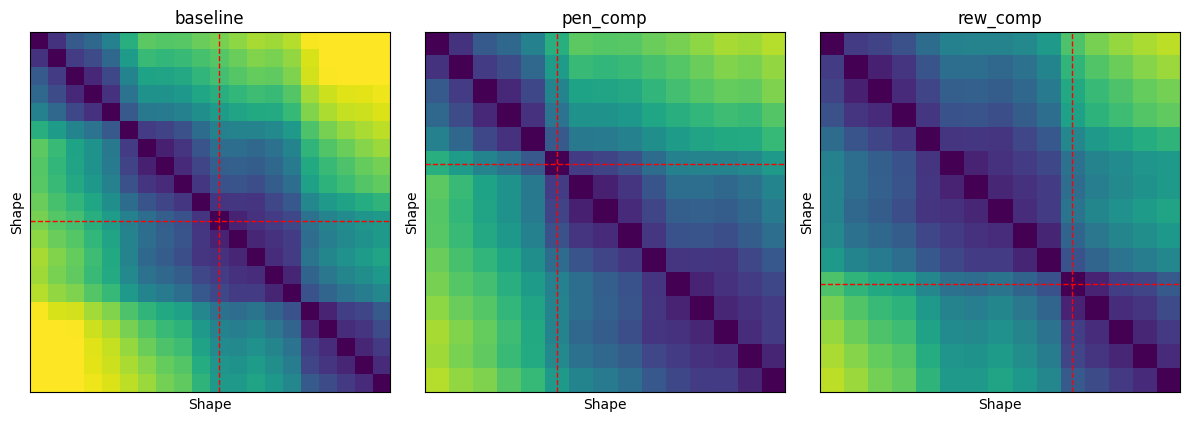

In [ ]:
hidden_cols = [col for col in nn_df.columns if col.startswith('hidden_')]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs, ax = axs.flatten(), 0
# fig.suptitle('RDMs', fontsize=16)

for cond, cond_df in nn_df.groupby('condition'):

    # since the df has duplicate shapes, take avg
    shape_feats = cond_df.groupby('shapes')[hidden_cols].mean().values
    rdm = squareform(pdist(shape_feats, metric='euclidean'))

    im = axs[ax].imshow(rdm, cmap='viridis')
    im = axs[ax].imshow(rdm, cmap='viridis', vmin=0, vmax=40)
        # ▶ plot red divider line at condition-specific index
    n = shape_feats.shape[0]
    if   cond == 'baseline': idx = n // 2
    elif cond == 'pen_comp': idx = n // 3
    elif cond == 'rew_comp':  idx = 2 * n // 3
    else:                     idx = None

    if idx is not None:
        axs[ax].axhline(idx, color='red', linestyle='--', linewidth=1)
        axs[ax].axvline(idx, color='red', linestyle='--', linewidth=1)

    axs[ax].set_title(f'{cond}')
    axs[ax].set_xlabel('Shape')
    axs[ax].set_ylabel('Shape')
    axs[ax].set_xticks([])
    axs[ax].set_yticks([])

    # fig.colorbar(im, ax=axs[ax], orientation='horizontal', pad=0.2, label='distance')
    ax += 1

plt.tight_layout()
plt.show()


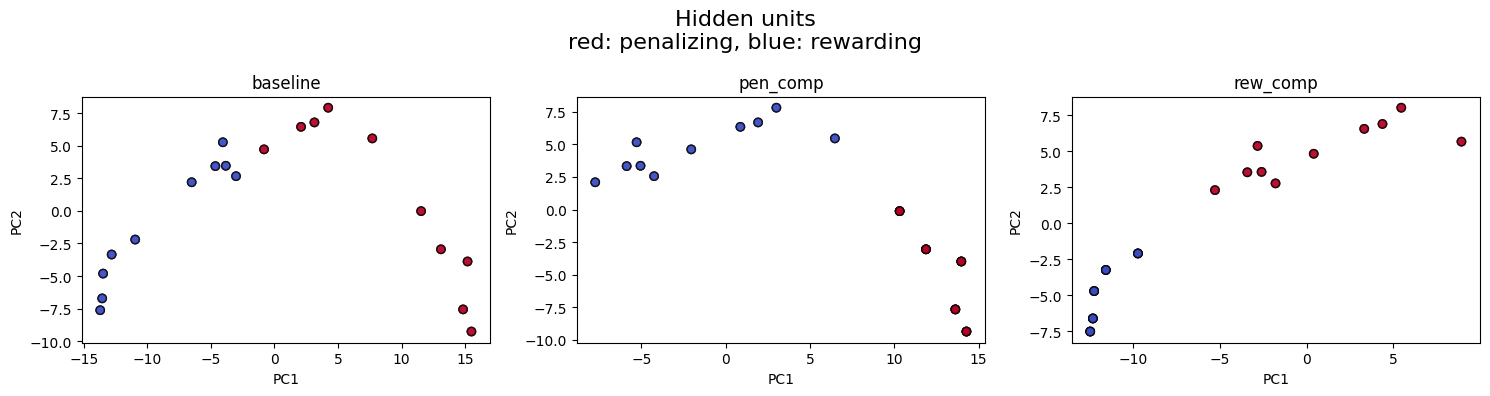

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0
fig.suptitle('Hidden units\nred: penalizing, blue: rewarding', fontsize=16)

for cond, cond_df in nn_df.groupby('condition'):
    
    scatter1 = axs[ax].scatter(cond_df['hidden_PC1'], cond_df['hidden_PC2'], c = cond_df['class_true'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
    axs[ax].set_xlabel('PC1')
    axs[ax].set_ylabel('PC2')
    axs[ax].set_title(f'{cond}')
    ax += 1

plt.tight_layout()
plt.show()


## distance from neutral

In [ ]:
# # 1. get 1D distance of each shape from divider
# nn_df['1D_dist_frm_div'] = nn_df['stim_pos'] - nn_df['div_true']

# # 2. get euclidean distance of each shape from divider
# euc_dists = []

# for shape_id in range(len(nn_df)):

#     div = nn_df['div_true'].iloc[shape_id]

#     # get indices of shapes to the immediate left and right of the divider
#     left_of_div_id = nn_df[np.isclose(nn_df['stim_pos'], div-.02)].index[0]
#     right_of_div_id = nn_df[np.isclose(nn_df['stim_pos'], div+.02)].index[0]

#     # compute centroid between shapes immediately left & right of div
#     centroid = np.mean([
#         hidden_df.iloc[left_of_div_id].values,
#         hidden_df.iloc[right_of_div_id].values
#     ], axis=0)

#     # store euclidean distance betw. shape and centroid
#     euc_dist = np.linalg.norm(hidden_df.iloc[shape_id].values - centroid)
#     euc_dists.append(euc_dist)

# nn_df['euc_dist_frm_div'] = euc_dists
# nn_df.iloc[75:85]


In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs, ax = axs.flatten(), 0
# fig.suptitle('Euclidean distance from divider', fontsize=16)
# jitter = .01

# for cond, cond_df in nn_df.groupby('condition'):

#     # plot euc dist (y) vs. 1D dist (x)
#     scatter = axs[ax].scatter(cond_df['1D_dist_frm_div'] + np.random.normal(0, jitter, size=len(cond_df)),
#                               cond_df['euc_dist_frm_div'] + np.random.normal(0, jitter, size=len(cond_df)),
#                               edgecolor='k', alpha=0.5, marker='o')

#     axs[ax].set_xlabel('1D distance')
#     axs[ax].set_ylabel('euclidean')
#     axs[ax].set_title(f'{cond}')
#     # axs[ax].set_ylim(0, 15)
#     axs[ax].set_xlim(-.4, .4)
#     ax += 1

# plt.tight_layout()
# plt.show()

## k-fold CV

In [ ]:
# from sklearn.model_selection import KFold

# # architecture params
# input_dim, hidden_dim, output_dim = n_feats, 128, n_feats
# model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# # loss params
# recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = 0, 5

# # convert to numpy arrays for compatibility with KFold
# X, y_recon, y_class = np.array(X), np.array(y_recon), np.array(y_class)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# fold_total_losses, fold_recon_losses, fold_class_losses = [], [], []
# epochs = 2500

# # CV loop
# for fold, (train_id, test_id) in enumerate(kf.split(X)):

#     print(f'fold {fold+1}', end=', ')

#     # split into train and test
#     X_train, X_test = X[train_id], X[test_id]
#     y_recon_train, y_recon_test = y_recon[train_id], y_recon[test_id]
#     y_class_train, y_class_test = y_class[train_id], y_class[test_id]

#     # initialize model, loss, and optimizer
#     model = ShapeSideNN(input_dim, hidden_dim, output_dim)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     epoch_total_losses, epoch_recon_losses, epoch_class_losses = [], [], []
#     beta = 3.0
#     # training loop
#     for epoch in range(epochs):
#         model.train()

#         # forward pass to predict reconstruction & class
#         pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))
#         pred_class_train = torch.sigmoid(pred_class_train)

#         # calculate training losses between pred & y
#         train_recon_loss = recon_loss_fn(pred_recon_train, torch.tensor(y_recon_train, dtype=torch.float32))
#         train_class_loss = class_loss_fn(pred_class_train, torch.tensor(y_class_train, dtype=torch.float32))
#         # weighted sum
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # backward pass and optimization; training
#         optimizer.zero_grad()
#         train_total_loss.backward()
#         optimizer.step()

#         # testing model
#         model.eval()
#         test_total_losses, test_recon_losses, test_class_losses = [], [], []
#         with torch.no_grad():

#             # predict left-out (test) shape & class based using trained model on left-out embeddings
#             pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))
#             pred_class_test = torch.sigmoid(pred_class_test)

#             # calculate testing losses between pred & y
#             test_recon_loss = recon_loss_fn(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))
#             test_class_loss = class_loss_fn(pred_class_test, torch.tensor(y_class_test, dtype=torch.float32))
#             test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

#         # appending epoch losses
#         epoch_recon_losses.append(test_recon_loss.item())
#         epoch_class_losses.append(test_class_loss.item())
#         epoch_total_losses.append(test_total_loss.item())

#     # appending fold losses
#     fold_recon_losses.append(epoch_recon_losses)
#     fold_class_losses.append(epoch_class_losses)
#     fold_total_losses.append(epoch_total_losses)

# # plot losses
# plt.figure(figsize=(8, 5))
# for i in range(5):
#     plt.plot(fold_total_losses[i], label=f'fold {i+1} class loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('5-fold CV')
# plt.legend()
# plt.show()
